In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\changjun\anaconda3\envs\tf_gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#tf.random.set_seed(11)

In [3]:
WIDTH = 28
HEIGHT = 28

def make_grid(images, nrow=5):
    n, h, w = images.shape
    ncol = (int)(n / 5)
    grid = np.zeros((ncol*h, nrow*w))

    idx = 0
    for i in range(ncol):
        for j in range(nrow):
            grid[HEIGHT*i:HEIGHT*(i+1), WIDTH*j:WIDTH*(j+1)] = images[idx]
            idx += 1
    
    return grid

def show_tensor_images(image_tensor, num_images=25):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = tf.squeeze(image_tensor.numpy())#.reshape(-1, HEIGHT, WIDTH)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid, cmap='gray')
    plt.show()

def get_noise(n_samples, z_dim):
    return tf.random.normal([n_samples, z_dim])

In [4]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
w_init = tf.keras.initializers.RandomNormal(0.0, 0.02)
b_init = tf.keras.initializers.Constant(0)

## Generator

In [6]:
class Generator(keras.Model):
    '''
    Generator Class
    Params:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = keras.Sequential([
            keras.layers.Input((1, 1, z_dim)),
            self.make_gen_block(hidden_dim * 4),
            self.make_gen_block(hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim),
            self.make_gen_block(im_chan, kernel_size=4, final_layer=True),
        ])
    
    def make_gen_block(self, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        ocrresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Params:
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return keras.Sequential([
                keras.layers.Conv2DTranspose(output_channels, kernel_size, stride),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU()
            ])
        else:
            return keras.Sequential([
                keras.layers.Conv2DTranspose(output_channels, kernel_size, stride),
                keras.layers.Activation('tanh')
            ])
    
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Params:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return tf.reshape(noise, (len(noise), 1, 1, self.z_dim))
    
    def call(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

## Critic

In [7]:
class Critic(keras.Model):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        
        self.disc = keras.Sequential([
            keras.layers.Input((WIDTH, HEIGHT, im_chan)),
            self.make_disc_block(hidden_dim),
            self.make_disc_block(hidden_dim * 2),
            self.make_disc_block(1, final_layer=True),
        ])
    
    def make_disc_block(self, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return keras.Sequential([
                keras.layers.Conv2D(output_channels, kernel_size, stride),
                keras.layers.BatchNormalization(),
                keras.layers.LeakyReLU(0.2),
            ])
        else:
            return keras.Sequential([
                keras.layers.Conv2D(output_channels, kernel_size, stride),
            ])
    
    def call(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return tf.reshape(disc_pred, (len(disc_pred), -1))

## Setting for initialization

In [8]:
BCELoss = keras.losses.BinaryCrossentropy(from_logits=True)
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 128
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5

def map_fn(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 127.5) / 127.5 # normalization between -1 and 1
    
    return x

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(map_fn).shuffle(1024).batch(batch_size)

In [9]:
gen = Generator(z_dim)
gen_opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
crit = Critic()
crit_opt = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

## Gradient Penalty

In [10]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)
    
    # Take the gradient of the scores with respect to the images
    with tf.GradientTape() as tape:
        tape.watch(mixed_images)
        
        # Calculate the critic's scores on the mixed images
        mixed_scores = crit(mixed_images)
    
    gradient = tape.gradient(mixed_scores, [mixed_images])[0]
    
    return gradient

In [11]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = tf.reshape(gradient, (len(gradient), -1))
    
    # Calculate the magnitude of every row
    gradient_norm = tf.norm(gradient, 2)
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = tf.math.reduce_mean((gradient_norm - 1) ** 2)
    #### END CODE HERE ####
    return penalty

## Losses

In [12]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -tf.math.reduce_mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [13]:
'''
1. The higher the mean fake score, the higher the critic's loss is.
2. What does this suggest about the mean real score?
3. The higher the gradient penalty, the higher the critic's loss is, proportional to lambda.
'''
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss = tf.math.reduce_mean(crit_fake_pred) - tf.math.reduce_mean(crit_real_pred) + c_lambda*gp
    #### END CODE HERE ####
    return crit_loss

  0%|          | 0/469 [00:00<?, ?it/s]

Step 50: Generator loss: -1.5459562838077545, critic loss: 20.25584716796875


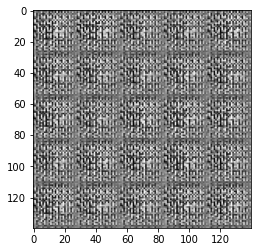

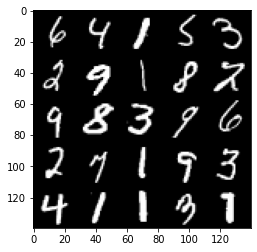

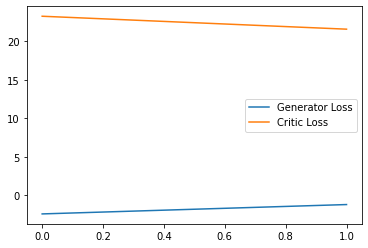

Step 100: Generator loss: 0.1613808424025774, critic loss: 1.8634285061359401


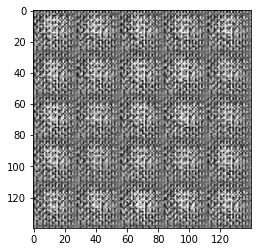

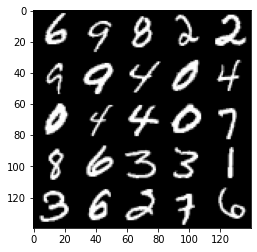

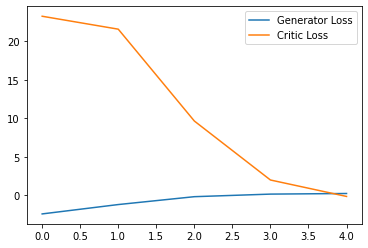

Step 150: Generator loss: 0.35336911380290986, critic loss: -0.5786656289100648


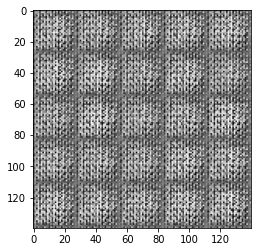

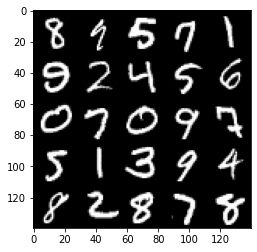

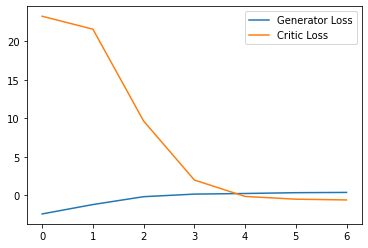

Step 200: Generator loss: 0.3000157657265663, critic loss: -0.6533425846099853


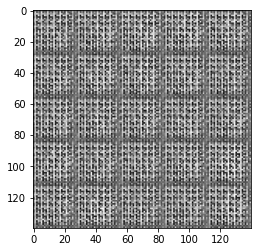

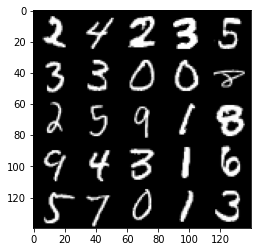

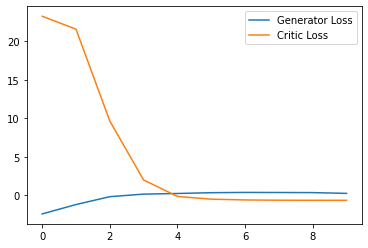

Step 250: Generator loss: 0.1393233971297741, critic loss: -0.626390563249588


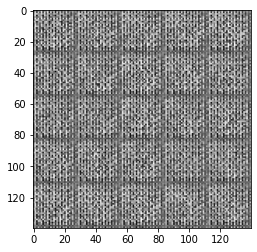

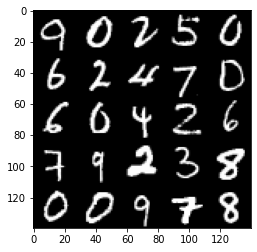

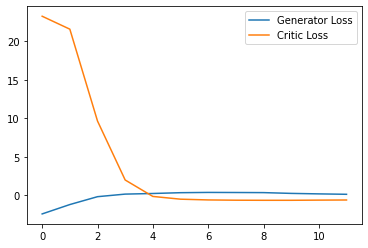

Step 300: Generator loss: 0.14671370893716812, critic loss: -0.5391478874087334


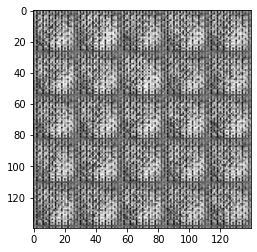

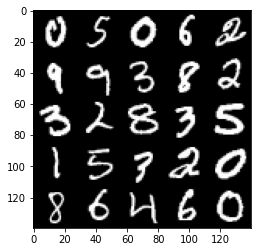

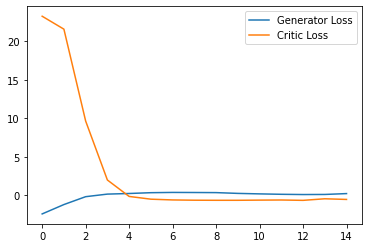

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []

for epoch in range(n_epochs):
    for real in tqdm(train_dataset):
        cur_batch_size = len(real)
        real = tf.expand_dims(real, axis=-1)
        
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            noise = get_noise(cur_batch_size, z_dim)
            
            with tf.GradientTape() as crit_tape:
                fake = gen(noise, training=True)
                crit_fake_pred = crit(fake, training=True)
                crit_real_pred = crit(real, training=True)
                
                epsilon = tf.random.uniform((len(real), 1, 1, 1))
                gradient = get_gradient(crit, real, fake, epsilon)
                gp = gradient_penalty(gradient)
                crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
            
            # Update gradients
            grads_of_crit = crit_tape.gradient(crit_loss, crit.trainable_variables)
            crit_opt.apply_gradients(zip(grads_of_crit, crit.trainable_variables))
            
            mean_iteration_critic_loss += crit_loss.numpy() / crit_repeats
        critic_losses += [mean_iteration_critic_loss]
        
        ### Update generator ###
        noise = get_noise(cur_batch_size, z_dim)
        
        with tf.GradientTape() as gen_tape:
            fake = gen(noise, training=True)
            crit_fake_pred = crit(fake, training=True)
            
            gen_loss = get_gen_loss(crit_fake_pred)
        
        # Update gradients
        grads_of_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
        gen_opt.apply_gradients(zip(grads_of_gen, gen.trainable_variables))
        
        generator_losses += [gen_loss.numpy()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                np.array(generator_losses[:num_examples]).reshape(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                np.array(critic_losses[:num_examples]).reshape(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1